# In-Depth: Support Vector Machines

# 深入：支持向量機

> Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

支持向量機（SVMs）是有監督學習算法中既能進行分類又能進行回歸的特別強大靈活的工具。本節中，我們會介紹支持向量機背後的機制以及它們在分類問題中的應用。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats

## Motivating Support Vector Machines

> As part of our disussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

在樸素貝葉斯分類中我們用於描述每個底層分類的分佈情況，並使用這些生成模型來預測新數據點的概率標籤的方法。那是*生成分類*的一個例子；本小節我們不考慮使用*判別式分類*：與其對每個類別進行建模，我們試圖簡單的尋找到一條曲線（二維空間）或流形（多維空間）能將每個類別區分出來。

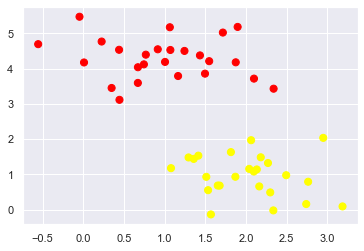

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

> A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes! We can draw them as follows:

一個線性判別分類器會試圖在兩個分類數據間畫出一條直線，通過這樣創建一個分類模型。對於像上面一樣的二維數據，這個任務可以手工完成。但是我們立刻就會碰到問題：這裡存在多條可能的直線能完美的劃分兩個分類。我們可以畫出如下三條直線：

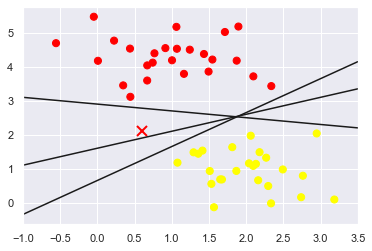

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

> These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

上圖中有三條非常不同的分割線，但是都能完美的區分這些樣本。取決於你選擇了哪條直線，新數據點（例如圖中標記為"X"的點）會被判定為不同的標籤。顯然簡單的“畫一條線分類”的簡單直覺是不夠的，我們需要更加深入地考慮這個問題。

## Support Vector Machines: Maximizing the *Margin*

## 支持向量機：最大化間距

> Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:> In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

支持向量機提供了一個方法來改進這個問題。這裡的原理是：與其簡單畫一條0寬度的線來分類，我們可以每條線上畫出一個有寬度的*間距*，直至最近的點為止。下面是一個例子：在支持向量機中，擁有最大化間距的線就是我們需要選擇的那個最優化模型。支持向量機就是這樣的*最大化間距*評估器。

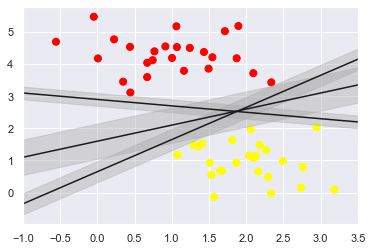

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

> In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

在支持向量機中，擁有最大化間距的線就是我們需要選擇的那個最優化模型。支持向量機就是這樣的*最大化間距*評估器。

### Fitting a support vector machine 訓練支持向量機

> we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

使用Scikit-Learn支持向量機分類器來訓練一個SVM模型。目前我們先使用一個線性的核並且將`C`參數設置為非常大的數值。

In [5]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

> To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

要更好的可視化展示發生的事情，我們創建一個快速的工具函數來繪製SVM的邊界：

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Grid
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Edge
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

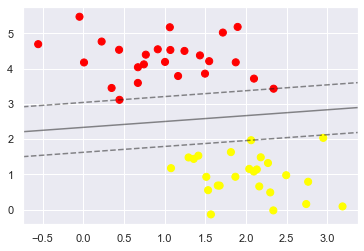

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

> This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

這條分割線將連個分類之間的間隔最大化了。注意到其中某些點正好接觸到邊緣：可以看到上圖中黑色虛線穿過的點被稱為*支持向量*，也是這個算法名稱的由來。在Scikit-Learn中，這些點的數據被保存在分類器的`support_vectors_`屬性中：

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

> A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin. We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

這個分類器成功的關鍵是在擬合過程中，只有那些支持向量的位置才有意義；任何其他超出邊緣範圍的點都不會改變訓練結果。技術上來說，這是因為這些點並不會為損失函數提供任何貢獻來擬合模型，所以它們不會通過邊緣區域，它們的位置和數值沒有意義。可以繪製這個模型通過前60個點的擬合結果以及前120個點的擬合結果來看到這一點：

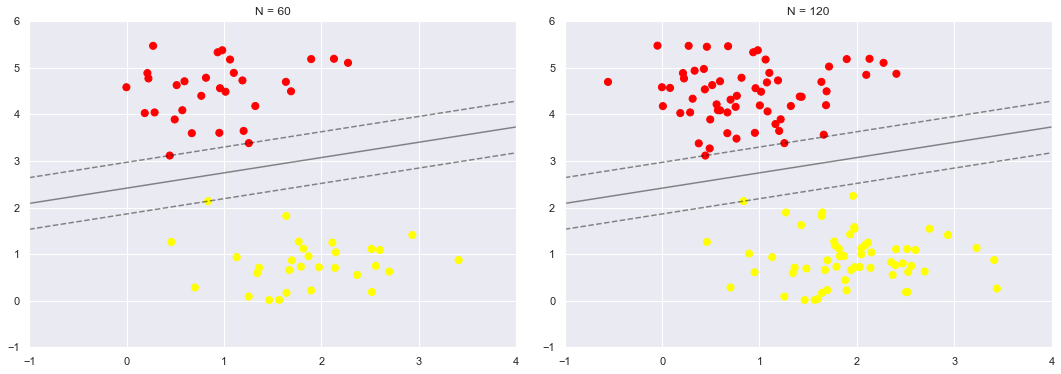

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

> In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

左圖中，我們看到前60個點生成的模型和支持向量。右圖中有兩倍數量的訓練點，但是模型並未發生變化：左右兩圖中的三個支持向量是相同的。這種對於遠離分隔區域的點的不敏感性是SVM模型的威力所在。

In [10]:
# Or use IPython show SVM
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…


> There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

我們將數據使用多項式和高斯函數投射到高維度空間中，然後就能使用線性分類器來擬合非線性的關係。

### Beyond linear boundaries: Kernel SVM 超出線性限制：核SVM

> It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

很明顯沒有線性分類器能夠將這些數據點分開。但是我們可以從[深入：線性回歸](05.06-Linear-Regression.ipynb)一節中的基本函數回歸類推過來，如果將數據投射到更高的維度，線性分類器就可以達到劃分數據的目標。例如下面使用的以中央的數據群為中心的*徑向基函數*：

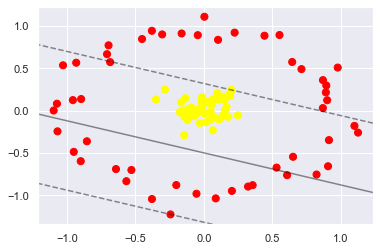

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [12]:
r = np.exp(-(X ** 2).sum(1))

> We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot: We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

可以使用三維圖表將這個轉換後的數據可視化出來，如果我們使用的是notebook交互模式，甚至還可以使用滑塊旋轉這個圖表：然後我們可以看到有了額外的維度後，數據變得線性可分，比方說我們可以在*r*=0.7的位置畫出一條分割線。

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

> Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

這個例子中我們需要仔細的選擇和調整我們的投射方式：如果我們沒有將徑向基函數的中心點放置在正確的位置上，就不能找到這樣清晰的線性分割線出來。通常如何進行選擇會是一個問題：我們希望有一種自動選擇最佳基函數的方法。這種基函數轉換被稱為*核轉換*，因為它建立在每一對數據點之間相似的關係（或稱為核）的基礎之上。

> A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

這種方法的潛在問題是，將$N$個點投射到$N$個維度上是非常消耗計算資源的，特別是$N$增大的情況下。但是因為存在一個被稱為[*核技巧*](https://en.wikipedia.org/wiki/Kernel_trick)的過程，在核轉換的數據上的擬合可以被隱式完成，也就是說不需要構建完整的$N$維核投射數據就可以完成訓練。這個和技巧內建在SVM中，也是這個算法如此強大的原因之一。

> In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

在Scikit-Learn中我們要應用核化的SVM，只需要簡單將線性的核改為RBF（徑向基函數）核，通過設置模型的`kernel`超參數即可：

In [14]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto')
clf.fit(X, y)

SVC(C=1000000.0, gamma='auto')

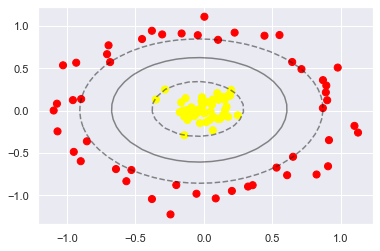

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

> Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

使用這個核化的支持向量機，我們得到了一條合適的非線性決定邊界。這種核轉換策略經常在機器學習中被使用在將線性方法轉變為快速的非線性方法的場合，特別適合能運用核技巧的模型中。

### Tuning the SVM: Softening Margins SVM調優：軟化邊緣

> Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

我們目前討論集中在非常乾淨的數據集上，也就是存在著完美的決定邊界。如果數據中存在一些重疊的話會怎麼樣？如下面看到的數據：

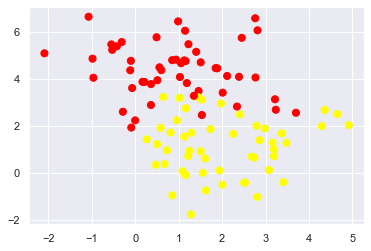

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

> To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.
The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit.
> The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).


要處理這種情況，SVM提供了一些附加因素用於*軟化邊緣*：意思就是，它允許一些數據點潛入到邊緣區域，如果這樣能達到更好的擬合效果的話。邊緣的硬度被一個稱為$C$的可調參數控制。如果$C$的值很大，邊緣是硬的，也就是數據點無法進入邊緣區域。如果$C$的值比較小，邊緣是軟的，能夠蔓延到點之外。調整$C$參數之後影響到最終擬合的情況：最優的$C$值取決於你的數據集，應該通過交叉驗證或者類似方法（參見[超參數和模型驗證](05.03-Hyperparameters-and-Model-Validation.ipynb)）來調整。

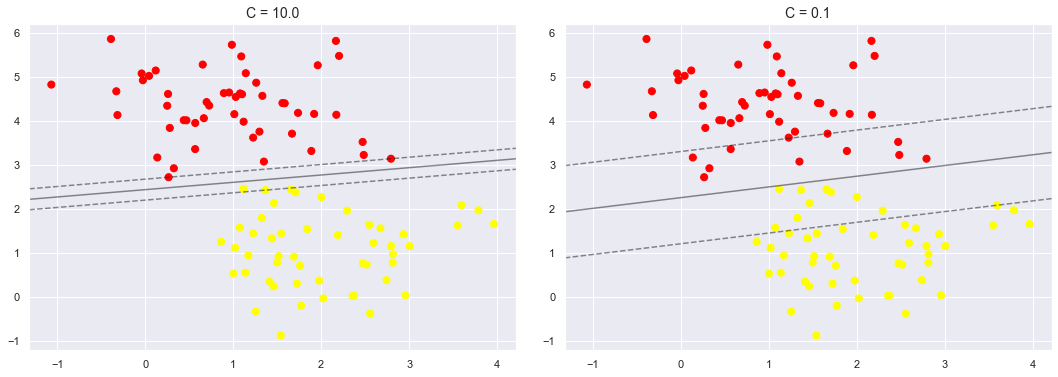

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

## Example: Face Recognition

## 例子：人臉識別

> As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

作為支持向量機的一個實際例子，讓我們來看一下人臉識別問題。我們使用的是一個標註好的數據集，其中包含著幾千張公眾人物的臉部照片。

In [18]:
# # fetch_lfw_people 資料量非常大
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Junichiro Koizumi' 'Tony Blair']
(1277, 62, 47)


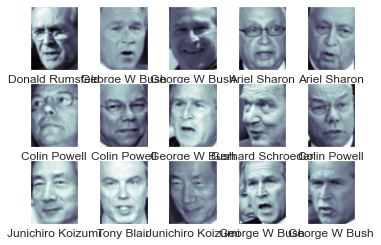

In [19]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

> Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

每張圖像含有[62×47]或者說將近3000像素點。我們將每個像素點作為數據集的一個特徵，但是通常來說更有效的做法是採用一些預處理器來提取圖像中有意義的特徵；這裡我們將採用主成分分析（參見[深入：主成分分析](05.09-Principal-Component-Analysis.ipynb)）來提取圖像中150個基礎成分，然後輸入到支持向量機分類器中。最簡單完成這項任務的方式是將預處理器和分類器連接成一個管道：

In [20]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

> For the sake of testing our classifier output, we will split the data into a training and testing set:

為了驗證我們分類器的性能，我們將數據分成訓練集和測試集：

In [21]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

> Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

最後，我們可以使用網格查找交叉驗證來檢驗模型超參數的組合。這裡我們會調整`C`（用來控制邊緣硬度）和`gamma`（用來控制徑向基函數核的大小），從中找到最佳模型：

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=3)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 45s, sys: 20.5 s, total: 2min 6s
Wall time: 37.9 s
{'svc__C': 5, 'svc__gamma': 0.005}


> The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

最優值應該落在網格的中央位置；如果它們落在邊緣位置，我們應該考慮擴大網格來確保我們找到了最優值。

> Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

現在我們有了經過交叉驗證後的模型，可以用來預測測試數據上的標籤了，這些數據是模型從來沒有接觸過的：

In [23]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

> Let's take a look at a few of the test images along with their predicted values:

下面我們看一下測試照片以及它們對應的預測標籤值：

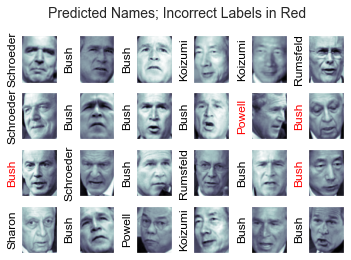

In [24]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

> Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

在這個小樣本中，我們優化過的評估器僅標錯了一個人的臉（最下面一行布什的臉被錯誤的標記成了布萊爾）。我們可以使用分類報告更好的得到評估器的性能估計，報告中我們對每個標籤都進驗證得出統計數據：

In [25]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.46      0.60        13
     Colin Powell       0.77      0.86      0.81        66
  Donald Rumsfeld       0.95      0.60      0.73        30
    George W Bush       0.82      0.96      0.88       139
Gerhard Schroeder       1.00      0.79      0.88        24
Junichiro Koizumi       1.00      0.71      0.83        17
       Tony Blair       0.92      0.77      0.84        31

         accuracy                           0.84       320
        macro avg       0.90      0.74      0.80       320
     weighted avg       0.85      0.84      0.84       320



> We might also display the confusion matrix between these classes:

當然我們也可以繪製這些分類之間的混淆矩陣：

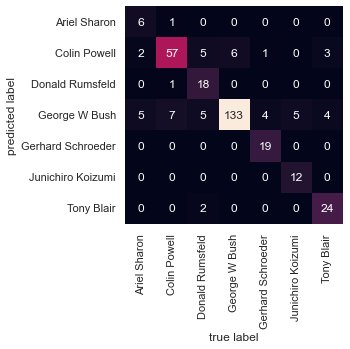

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

> This helps us get a sense of which labels are likely to be confused by the estimator.

上面的矩阵能帮助我们建立评估器在每个标签上性能的直观印象。

> For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

在真实的人脸识别任务中，人脸的照片并没有预先裁剪成一个网格，与例子中的唯一区别在于特征选择部分：你可能需要使用一个复杂得多的算法来找到人脸，并将其中像素中独立的特征提取出来。对于这类应用，[OpenCV](http://opencv.org)是一个很好的选择，因为它其中已经內建了预训练的特征提取工具实现，无论是通用的图像还是人脸的照片。

### Example

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv("input/ml-product.csv")
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0
...,...,...,...,...,...
395,15691863,Female,46.0,41000.0,1
396,15706071,Male,51.0,23000.0,1
397,15654296,Female,50.0,20000.0,1
398,15755018,Male,36.0,33000.0,0


In [30]:
from sklearn.preprocessing import StandardScaler

X=data.iloc[:,[2,3]].values
Y=data.iloc[:,4].values
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X_scaled,Y,test_size=0.2)

In [32]:
#Fitting a support vector machine 
from sklearn.svm import SVC

model=SVC(kernel='linear')
model.fit(X_train,Y_train)

SVC(kernel='linear')

In [33]:
Y_predicted=model.predict(X_test)
print(Y_test,Y_predicted)

[0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1
 0 0 1 0 0 0] [0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 0]


In [34]:
from sklearn.metrics import confusion_matrix

matrix=confusion_matrix(Y_test,Y_predicted)
matrix

array([[50,  2],
       [10, 18]])

## Support Vector Machine Summary

## 支持向量機總結

> We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

> - Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

本節內容對支持向量機背後的原理進行了簡要直觀的介紹。這些方法在分類任務中非常強大的原因在於：

- 它們僅依賴於很少的支持向量，這意味著它們是非常緊湊的模型，佔用的內存也非常少。
- 一旦模型訓練好了，預測階段非常快速。
- 因為它們僅受到邊緣區域附近數據點的影響，所以它們在高維度數據上也工作良好，甚至數據的特徵維度比樣本數還多的情況下。這對於其他算法來說基本是一個具挑戰性的領域。
- 將它們與核方法集成之後將會非常靈活強大，能夠適用多種類型的數據。

> However, SVMs have several disadvantages as well:

> - The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

當然，SVM也有如下一些缺點：

- 算法複雜度在樣本數為$N$的情況下，最差是$\mathcal{O}[N^3]$，最好實現是$\mathcal{O}[N^2]$。這導致訓練集特別大的情況下，這個計算代價是無法承受的。
- 算法的性能結果很大程度上依賴於邊緣軟化參數$C$的選擇。這需要通過交叉驗證來小心選擇，在數據集增大時該操作也是非常昂貴的。
- 結果沒有直接的概率解釋。雖然可以通過內部的交叉驗證（參見`SVC`分類器的`probability`參數）來估計，但是要更精確的估算是困難的。

> With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

有了上面的特性，作者通過僅會在其他簡單快速和更少超參調節的方法無法滿足的情況下採用SVM。然而，如果你有很好的計算資源來完成SVM的訓練和交叉驗證的話，這個方法能提供優異的結果。

<!--NAVIGATION-->
< [深入：线性回归](05.06-Linear-Regression.ipynb) | [目录](Index.ipynb) | [深入：决策树和随机森林](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
